### Sample program for grid search of hyper parameters  

#### Import libraries  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from joblib import dump

#### Parameters  

In [2]:
csv_in = 'winequality-white_small.csv'

#### Read CSV file  

In [3]:
df = pd.read_csv(csv_in, delimiter=',', skiprows=0, header=0)
print(df.shape)
print(df.info())
display(df.head())

(1223, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1223 entries, 0 to 1222
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed_acidity         1223 non-null   float64
 1   volatile_acidity      1223 non-null   float64
 2   citric_acid           1223 non-null   float64
 3   residual_sugar        1223 non-null   float64
 4   chlorides             1223 non-null   float64
 5   free_sulfur_dioxide   1223 non-null   float64
 6   total_sulfur_dioxide  1223 non-null   float64
 7   density               1223 non-null   float64
 8   pH                    1223 non-null   float64
 9   sulphates             1223 non-null   float64
 10  alcohol               1223 non-null   float64
 11  quality               1223 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 114.8 KB
None


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,6.2,0.32,0.16,7.00,0.045,30.0,136.0,0.9949,3.18,0.47,9.6,6
1,8.1,0.27,0.41,1.45,0.033,11.0,63.0,0.9908,2.99,0.56,12.0,5
2,7.9,0.18,0.37,1.20,0.040,16.0,75.0,0.9920,3.18,0.63,10.8,5
3,6.6,0.17,0.38,1.50,0.032,28.0,112.0,0.9914,3.25,0.55,11.4,7
4,6.2,0.66,0.48,1.20,0.029,29.0,75.0,0.9892,3.33,0.39,12.8,8


#### Get X and y  

In [4]:
X = df.iloc[:, :-1]  # explanatory variables
y = df['quality']  # objective variable
print('X:', X.shape)
display(X.head())
print('y:', y.shape)
print(y.head())

X: (1223, 11)


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
0,6.2,0.32,0.16,7.00,0.045,30.0,136.0,0.9949,3.18,0.47,9.6
1,8.1,0.27,0.41,1.45,0.033,11.0,63.0,0.9908,2.99,0.56,12.0
2,7.9,0.18,0.37,1.20,0.040,16.0,75.0,0.9920,3.18,0.63,10.8
3,6.6,0.17,0.38,1.50,0.032,28.0,112.0,0.9914,3.25,0.55,11.4
4,6.2,0.66,0.48,1.20,0.029,29.0,75.0,0.9892,3.33,0.39,12.8


y: (1223,)
0    6
1    5
2    5
3    7
4    8
Name: quality, dtype: int64


#### Make pipeline and set parameters for grid search   

In [5]:
abc=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), random_state=3)            

param_grid = {
    'n_estimators': [10, 50, 100],
    'learning_rate': [0.1, 0.5, 1.0],
    'base_estimator__max_depth': [2, 4, 6, None],
}

#### Preparation of objects for cross validation  

In [6]:
grid_cv = KFold(n_splits=4, shuffle=True, random_state=5)  # for grid search
gen_cv = KFold(n_splits=4, shuffle=True, random_state=7)  # for estimation of generalization performance

#### Define the grid search for hyperparameters  

In [7]:
gs = GridSearchCV(abc, param_grid , cv=grid_cv, scoring='neg_mean_squared_error')

#### Estimation of generalization performance  

In [8]:
%%time
nested_score = cross_val_score(gs, X=X, y=y, cv=gen_cv,
                               scoring='neg_mean_squared_error')
print(nested_score)
print(np.sqrt(-nested_score.mean()))

[-0.58823529 -0.62745098 -0.55228758 -0.59344262]
0.7683450525577636
CPU times: user 1min 4s, sys: 166 ms, total: 1min 4s
Wall time: 1min 4s


**Generalization performance (RMSE) / 汎化性能 (平均2乗誤差平方根): 0.675**  

#### Cross-validation to obtain the model with the best hyperparameter set (best estimator)  
- Note: gs_best is already fit to the whole data (X) in gs.fit(X, y)  

In [9]:
%%time
gs.fit(X, y)
gs_best = gs.best_estimator_

CPU times: user 19.6 s, sys: 48 ms, total: 19.7 s
Wall time: 19.7 s


In [14]:
print(gs_best)
for k,v in gs_best.get_params(deep=True).items():
    print(k, '->', v)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=6),
                   n_estimators=100, random_state=3)
algorithm -> SAMME.R
base_estimator__ccp_alpha -> 0.0
base_estimator__class_weight -> None
base_estimator__criterion -> gini
base_estimator__max_depth -> 6
base_estimator__max_features -> None
base_estimator__max_leaf_nodes -> None
base_estimator__min_impurity_decrease -> 0.0
base_estimator__min_impurity_split -> None
base_estimator__min_samples_leaf -> 1
base_estimator__min_samples_split -> 2
base_estimator__min_weight_fraction_leaf -> 0.0
base_estimator__random_state -> None
base_estimator__splitter -> best
base_estimator -> DecisionTreeClassifier(max_depth=6)
learning_rate -> 1.0
n_estimators -> 100
random_state -> 3


#### Show feature importances of the best model  

In [11]:
print(pd.Series(gs_best.feature_importances_, index=X.columns))

fixed_acidity           0.083473
volatile_acidity        0.098710
citric_acid             0.086395
residual_sugar          0.082597
chlorides               0.097672
free_sulfur_dioxide     0.103686
total_sulfur_dioxide         NaN
density                 0.068587
pH                      0.096560
sulphates               0.106885
alcohol                 0.075145
dtype: float64


/home/anhvu/miniconda3/envs/iniad_ai/lib/python3.8/site-packages/sklearn/tree/_classes.py:605: RuntimeWarning: invalid value encountered in true_divide
  return self.tree_.compute_feature_importances()


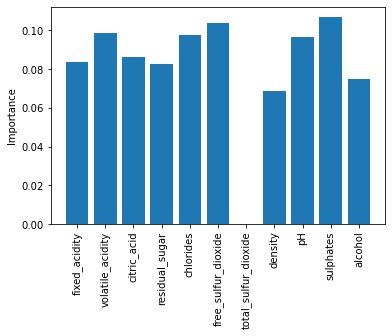

In [12]:
plt.bar(X.columns, gs_best.feature_importances_)
plt.ylabel('Importance')
plt.xticks(rotation=90)
plt.show()

**Features (explanatory variable) with the largest importance: alcohol**  
**重要度が最大の説明変数(特徴量): alcohol**  

#### Save the best predictor  

In [13]:
tag = '12-assign1'
model_file = 'abr_best_ai-{}.joblib'.format(tag)
dump(gs_best, model_file)

['abr_best_ai-12-assign1.joblib']